# Imports

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import random

In [2]:
SEED = 666
DATA_FILE = '../Datasets/cats/data/breeds_data_final.pkl'
IMAGES_DIR = '../Datasets/cats/images'
FIGURES_DIR = '../Figures/'
CHECKPOINTS_DIR = '../History'
RESOLUTION = 128
LABELS = 'coat'

In [3]:
random.seed(SEED)
np.random.seed(SEED)

In [4]:
data = pd.read_pickle(DATA_FILE)
data

,age,gender,size,coat,breed,image
3,1.0,0.0,3.0,2.0,0.0,Abyssinian/46620170_3.jpg
7,0.0,1.0,2.0,2.0,0.0,Abyssinian/46463847_8.jpg
11,2.0,1.0,2.0,2.0,0.0,Abyssinian/46305208_12.jpg
12,0.0,0.0,2.0,2.0,0.0,Abyssinian/46301725_13.jpg
13,3.0,1.0,3.0,2.0,0.0,Abyssinian/46293180_14.jpg
...,...,...,...,...,...,...
67140,1.0,1.0,2.0,2.0,65.0,Tuxedo/43781057_7295.jpg
67141,0.0,0.0,2.0,2.0,65.0,Tuxedo/43773439_7304.jpg
67142,3.0,0.0,1.0,2.0,65.0,Tuxedo/43773383_7305.jpg
67143,0.0,1.0,2.0,1.0,65.0,Tuxedo/43773168_7306.jpg


In [5]:
# Cats data string convertor
# Data was collected from Analysis/cats/cats_prediction_2.ipynb
age_list = ['Adult', 'Baby', 'Senior', 'Young']
gender_list = ['Female', 'Male']
size_list = ['Extra Large', 'Large', 'Medium', 'Small']
coat_list = ['Long', 'Medium', 'Short']
breed_list = ['Abyssinian', 'American Bobtail', 'American Curl',
        'American Shorthair', 'American Wirehair', 'Applehead Siamese',
        'Balinese', 'Bengal', 'Birman', 'Bombay', 'British Shorthair',
        'Burmese', 'Burmilla', 'Calico', 'Canadian Hairless', 'Chartreux',
        'Chausie', 'Chinchilla', 'Cornish Rex', 'Cymric', 'Devon Rex',
        'Dilute Calico', 'Dilute Tortoiseshell', 'Domestic Long Hair',
        'Domestic Medium Hair', 'Domestic Short Hair', 'Egyptian Mau',
        'Exotic Shorthair', 'Extra-Toes Cat - Hemingway Polydactyl',
        'Havana', 'Himalayan', 'Japanese Bobtail', 'Javanese', 'Korat',
        'LaPerm', 'Maine Coon', 'Manx', 'Munchkin', 'Nebelung',
        'Norwegian Forest Cat', 'Ocicat', 'Oriental Long Hair',
        'Oriental Short Hair', 'Oriental Tabby', 'Persian', 'Pixiebob',
        'Ragamuffin', 'Ragdoll', 'Russian Blue', 'Scottish Fold',
        'Selkirk Rex', 'Siamese', 'Siberian', 'Silver', 'Singapura',
        'Snowshoe', 'Somali', 'Sphynx - Hairless Cat', 'Tabby', 'Tiger',
        'Tonkinese', 'Torbie', 'Tortoiseshell', 'Turkish Angora',
        'Turkish Van', 'Tuxedo', 'York Chocolate']

def get_cat_string(cat, value):
    if(cat == 'age'):
        return age_list[int(value)]
    elif(cat == 'gender'):
        return gender_list[int(value)]
    elif(cat == 'size'):
        return size_list[int(value)]
    elif(cat == 'coat'):
        return coat_list[int(value)]
    elif(cat == 'breed'):
        return breed_list[int(value)]

In [6]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [7]:
# Load images from paths stored in the dataframe
def load_images(df):
    images = []
    for path in df['image']:
        #print(os.path.join(IMAGES_DIR, path))
        img = load_img(os.path.join(IMAGES_DIR, path), target_size=(RESOLUTION, RESOLUTION))
        img = img_to_array(img)
        img = np.expand_dims(img, axis=0)
        #img = cv2.imread(os.path.join(IMAGES_DIR, path), cv2.COLOR_RGB2BGR)
        #img = cv2.resize(img, (RESOLUTION, RESOLUTION))
        images.append(img.astype(np.float32) / 255.0)
        #images.append(img)
    return np.vstack(images)

In [8]:
images = load_images(data)

In [9]:
# Process data in analysis.ipynb
print(data.iloc[:, 4].shape)
print(images.shape)

(41939,)
(41939, 128, 128, 3)


29892 Baby Male Small Short
24708 Adult Female Small Long
28467 Adult Female Medium Long
18579 Adult Female Medium Short


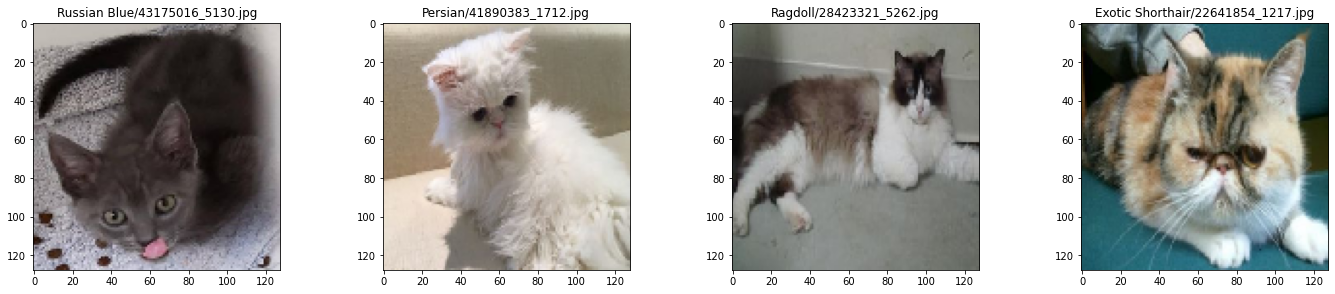

In [10]:
# Plotting 4 cats with their matching info
fig = plt.figure(figsize=(24, 10))
for i, r in enumerate([random.randint(0, images.shape[0]) for _ in range(4)]):
    ax = plt.subplot(2, 4, i + 1)
    ax.set_title(data.iloc[r, 5])
    ax.imshow(images[r])
    print(r, get_cat_string('age', data.iloc[r, 0]), get_cat_string('gender', data.iloc[r, 1]), get_cat_string('size', data.iloc[r, 2]), get_cat_string('coat', data.iloc[r, 3]))

In [11]:
# Import ml libraries
from tensorflow.keras import models, layers, optimizers, callbacks
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf

if tf.test.gpu_device_name():
   print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [12]:
# Chekpoints callback function
def make_checkpoints(name):
    return callbacks.ModelCheckpoint(filepath=os.path.join(CHECKPOINTS_DIR, name + '.ckpt'), save_weights_only=True, verbose=1)

In [13]:
# Plot graphs functions
def plot_accuracy(history, path):
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label = 'Accuracy_Val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.savefig(path)
    plt.show()
def plot_loss(history, path):
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label = 'Loss_Val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.savefig(path)
    plt.show()

In [37]:
# Datasets

# One-hot encoding
label_cols = pd.DataFrame(
    to_categorical(data[LABELS]), 
    columns=['l' + str(i+1) for i in range(len(data[LABELS].unique()))]
)
label_cols.index = data.index

# Split into 0.6:0.2:0.2
X_cat_train, X_cat_test, y_train, y_test = train_test_split(
    data.drop([LABELS], axis=1), 
    label_cols, 
    test_size=0.2, 
    random_state=1)
X_cat_train, X_cat_val, y_train, y_val = train_test_split(
    X_cat_train, y_train, test_size=0.25, random_state=1)

# Load images from paths stored in each dataframe
X_img_train = load_images(X_cat_train)
X_img_test = load_images(X_cat_test)
X_img_val = load_images(X_cat_val)

# Remove the image column containing paths
X_cat_train = X_cat_train.drop(['image'], axis=1)
X_cat_test = X_cat_test.drop(['image'], axis=1)
X_cat_val = X_cat_val.drop(['image'], axis=1)

print(X_cat_train.shape, X_cat_test.shape, X_cat_val.shape)
print(X_img_train.shape, X_img_test.shape, X_img_val.shape)

(25163, 4) (8388, 4) (8388, 4)
(25163, 128, 128, 3) (8388, 128, 128, 3) (8388, 128, 128, 3)


In [40]:
# Correlation map for temp choice on labels
def get_corr_map(data):
    corr = data.corr()
    plt.figure(figsize=(4, 4), dpi=100, facecolor='w', edgecolor='k')
    colormap = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(colormap)
    plt.title('Correlation Map')
    plt.show()
    return corr

# Correlations for categorical attributes
- Size and Gender
- Coat and Size

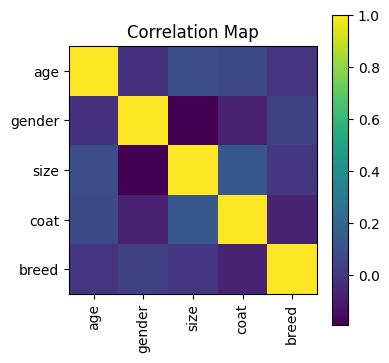

,age,gender,size,coat,breed
age,1.000000,-0.018718,0.095492,0.071828,-0.006869
gender,-0.018718,1.000000,-0.190893,-0.081781,0.035960
size,0.095492,-0.190893,1.000000,0.137256,-0.002803
coat,0.071828,-0.081781,0.137256,1.000000,-0.070799
breed,-0.006869,0.035960,-0.002803,-0.070799,1.000000


In [41]:
get_corr_map(data)

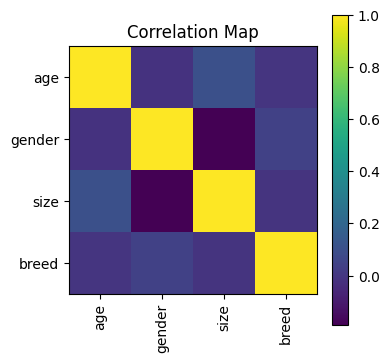

,age,gender,size,breed
age,1.000000,-0.015417,0.100114,-0.008288
gender,-0.015417,1.000000,-0.189885,0.040378
size,0.100114,-0.189885,1.000000,-0.010068
breed,-0.008288,0.040378,-0.010068,1.000000


In [42]:
get_corr_map(X_cat_train)

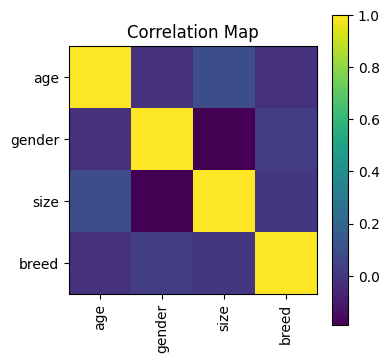

,age,gender,size,breed
age,1.000000,-0.018758,0.091553,-0.017600
gender,-0.018758,1.000000,-0.189517,0.028329
size,0.091553,-0.189517,1.000000,0.005472
breed,-0.017600,0.028329,0.005472,1.000000


In [43]:
get_corr_map(X_cat_test)

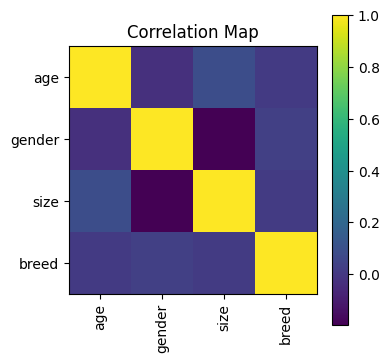

,age,gender,size,breed
age,1.000000,-0.028693,0.085433,0.008404
gender,-0.028693,1.000000,-0.195348,0.030349
size,0.085433,-0.195348,1.000000,0.010877
breed,0.008404,0.030349,0.010877,1.000000


In [44]:
get_corr_map(X_cat_val)

# Networks

In [15]:
from tensorflow.keras import Input, Model

## Test 1

In [45]:
# Name for outputs
n = 'final_cnn_combined_1'

In [46]:
# Categorical Features - Input Layer 1
input_cat = Input(shape=(4,))

x_cat = layers.Dense(32)(input_cat)
x_cat = layers.Dense(64)(x_cat)
x_cat = layers.Dense(128)(x_cat)

x_cat = Model(inputs=input_cat, outputs=x_cat)

x_cat.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_16 (Dense)             (None, 32)                160       
_________________________________________________________________
dense_17 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_18 (Dense)             (None, 128)               8320      
Total params: 10,592
Trainable params: 10,592
Non-trainable params: 0
_________________________________________________________________


In [47]:
# Visual Features - Input Layer 2
input_img = Input(shape=(RESOLUTION, RESOLUTION, 3))

x_img = layers.Conv2D(32, (3, 3), activation='relu')(input_img)
x_img = layers.MaxPooling2D((2, 2))(x_img)
x_img = layers.Conv2D(128, (3, 3), activation='relu')(x_img)
x_img = layers.MaxPooling2D((2, 2))(x_img)
x_img = layers.Conv2D(128, (3, 3), activation='relu')(x_img)
x_img = layers.MaxPooling2D((2, 2))(x_img)
x_img = layers.Flatten()(x_img)
x_img = layers.Dropout(0.5)(x_img)

x_img = Model(inputs=input_img, outputs=x_img)

x_img.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 61, 61, 128)       36992     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 128)       147584    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 128)       0  

In [52]:
# Combine Model
combine_input = layers.Concatenate(axis=1)([x_cat.output, x_img.output])

x_combine = layers.Dense(256, activation='sigmoid')(combine_input)
x_combine = layers.Dense(len(data[LABELS].unique()), activation='softmax')(x_combine)

model_1 = Model(inputs=[x_cat.input, x_img.input], outputs = x_combine)
model_1.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 126, 126, 32) 896         input_6[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 63, 63, 32)   0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 61, 61, 128)  36992       max_pooling2d_6[0][0]            
___________________________________________________________________________________________

In [54]:
# Test 1
epochs = 10

model_1.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
history_1 = model_1.fit(
    x = [X_cat_train, X_img_train],
    y = y_train,
    validation_data = ([X_cat_val, X_img_val], y_val),
    epochs=epochs,
    callbacks=[make_checkpoints(n)]
)

Epoch 1/10
787/787 [==============================] - 36s 44ms/step - loss: 0.5008 - accuracy: 0.6548 - val_loss: 0.4284 - val_accuracy: 0.7154

Epoch 00001: saving model to ../History\final_cnn_combined_1.ckpt
Epoch 2/10
787/787 [==============================] - 33s 42ms/step - loss: 0.4195 - accuracy: 0.7199 - val_loss: 0.4531 - val_accuracy: 0.6949

Epoch 00002: saving model to ../History\final_cnn_combined_1.ckpt
Epoch 3/10
787/787 [==============================] - 37s 47ms/step - loss: 0.3857 - accuracy: 0.7423 - val_loss: 0.4425 - val_accuracy: 0.7014

Epoch 00003: saving model to ../History\final_cnn_combined_1.ckpt
Epoch 4/10
787/787 [==============================] - 48s 61ms/step - loss: 0.3471 - accuracy: 0.7739 - val_loss: 0.4432 - val_accuracy: 0.7157

Epoch 00004: saving model to ../History\final_cnn_combined_1.ckpt
Epoch 5/10
787/787 [==============================] - 34s 44ms/step - loss: 0.2968 - accuracy: 0.8114 - val_loss: 0.4563 - val_accuracy: 0.6978

Epoch 00005

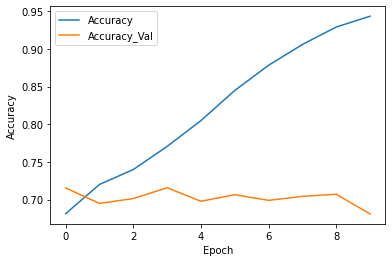

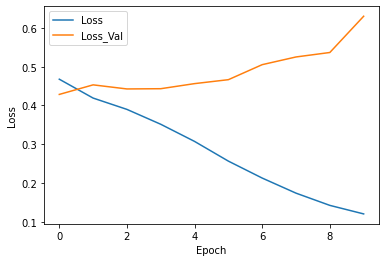

In [56]:
# Show and Export graphs
plot_accuracy(history_1, os.path.join(FIGURES_DIR, n + '_' + str(epochs) + '_acc.png'))
plot_loss(history_1, os.path.join(FIGURES_DIR, n + '_' + str(epochs) + '_loss.png'))

## Test 2

In [57]:
# Name for outputs
n = 'final_cnn_combined_2'

In [58]:
# Categorical Features - Input Layer 1
input_cat = Input(shape=(4,))

x_cat = layers.Dense(32)(input_cat)
x_cat = layers.Dense(32)(x_cat)
x_cat = layers.Dense(64)(x_cat)
x_cat = layers.Dense(64)(x_cat)
x_cat = layers.Dense(128)(x_cat)
x_cat = layers.Dense(128)(x_cat)

x_cat = Model(inputs=input_cat, outputs=x_cat)

x_cat.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_23 (Dense)             (None, 32)                160       
_________________________________________________________________
dense_24 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_25 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_26 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_27 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_28 (Dense)             (None, 128)               165

In [59]:
# Visual Features - Input Layer 2
input_img = Input(shape=(RESOLUTION, RESOLUTION, 3))

x_img = layers.Conv2D(32, (3, 3), activation='relu')(input_img)
x_img = layers.MaxPooling2D((2, 2))(x_img)
x_img = layers.Conv2D(128, (3, 3), activation='relu')(x_img)
x_img = layers.MaxPooling2D((2, 2))(x_img)
x_img = layers.Conv2D(128, (3, 3), activation='relu')(x_img)
x_img = layers.MaxPooling2D((2, 2))(x_img)
x_img = layers.Flatten()(x_img)
x_img = layers.Dropout(0.5)(x_img)

x_img = Model(inputs=input_img, outputs=x_img)

x_img.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 61, 61, 128)       36992     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 128)       147584    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 128)       0  

In [61]:
# Combine Model
combine_input = layers.Concatenate(axis=1)([x_cat.output, x_img.output])

x_combine = layers.Dense(512, activation='relu')(combine_input)
x_combine = layers.Dense(len(data[LABELS].unique()), activation='sigmoid')(x_combine)

model_2 = Model(inputs=[x_cat.input, x_img.input], outputs = x_combine)
model_2.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 126, 126, 32) 896         input_8[0][0]                    
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 63, 63, 32)   0           conv2d_9[0][0]                   
___________________________________________________________________________________________

In [62]:
epochs = 50
opt = optimizers.SGD(lr=0.01, momentum=0.9, decay=0.01)

model_2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
history_2 = model_2.fit(
    x = [X_cat_train, X_img_train],
    y = y_train,
    validation_data = ([X_cat_val, X_img_val], y_val),
    epochs=epochs,
    callbacks=[make_checkpoints(n)]
)

Epoch 1/10
787/787 [==============================] - 37s 46ms/step - loss: 0.5176 - accuracy: 0.6319 - val_loss: 0.4778 - val_accuracy: 0.6530

Epoch 00001: saving model to ../History\final_cnn_combined_2.ckpt
Epoch 2/10
787/787 [==============================] - 36s 46ms/step - loss: 0.4802 - accuracy: 0.6546 - val_loss: 0.4722 - val_accuracy: 0.6606

Epoch 00002: saving model to ../History\final_cnn_combined_2.ckpt
Epoch 3/10
787/787 [==============================] - 36s 46ms/step - loss: 0.4779 - accuracy: 0.6573 - val_loss: 0.4689 - val_accuracy: 0.6875

Epoch 00003: saving model to ../History\final_cnn_combined_2.ckpt
Epoch 4/10
787/787 [==============================] - 36s 46ms/step - loss: 0.4738 - accuracy: 0.6702 - val_loss: 0.4687 - val_accuracy: 0.6814

Epoch 00004: saving model to ../History\final_cnn_combined_2.ckpt
Epoch 5/10
787/787 [==============================] - 36s 46ms/step - loss: 0.4730 - accuracy: 0.6765 - val_loss: 0.4629 - val_accuracy: 0.6936

Epoch 00005

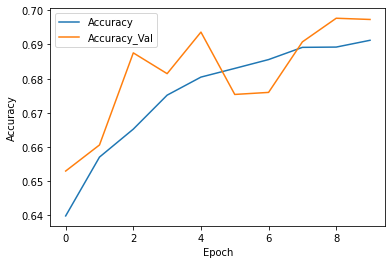

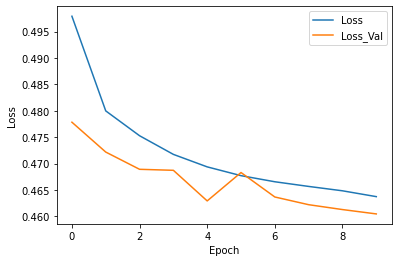

In [65]:
# Show and Export graphs
plot_accuracy(history_2, os.path.join(FIGURES_DIR, n + '_' + str(epochs) + '_acc.png'))
plot_loss(history_2, os.path.join(FIGURES_DIR, n + '_' + str(epochs) + '_loss.png'))